# Transfer Learning with RAG Models
----
**Objective**: In this notebook, you will experiment with a QA RAG model on the climate_fever dataset using the Haystack framework. You will get to go through the whole process of fitting the parts of a RAG model together, and learn how to prompt it with queries to get answers from the provided dataset.

NOTE: Make sure to change the runtime from CPU to TPU or GPU for faster training

## Install Libraries
Install the Haystack (for colab) and Datasets libraries

In [1]:
!pip install farm-haystack[colab]
!pip install datasets

## Import Dataset
----
In this section, we will use as an example the climate_fever dataset. The dataset consists of 1535 rows of claims about climate change, and they either refute or support climate change, with some claims being neutral. We will build with a specific topic in mind so that we can get more accurate answers, and keep in mind that bigger datasets with open topics can also be used.

**Question 1**: Use the "load_dataset" function to load the "climate_fever" dataset with the "test" split.

In [2]:
from datasets import load_dataset

dataset=load_dataset("climate_fever",split='test')
dataset.features['evidences'] #lets show the labels

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


[{'evidence_id': Value(dtype='string', id=None),
  'evidence_label': ClassLabel(names=['SUPPORTS', 'REFUTES', 'NOT_ENOUGH_INFO'], id=None),
  'article': Value(dtype='string', id=None),
  'evidence': Value(dtype='string', id=None),
  'entropy': Value(dtype='float32', id=None),
  'votes': [Value(dtype='string', id=None)]}]

## Formatting and Writing Documents
----
First, we need to extract, format and write the documents from our chosen dataset so that we can later build our QA Pipeline. This Pipeline will facilitate the process of building our RAG model and getting answers from it.

Keep in mind that for this notebook we will focus on how to build the pipeline with the simplest configurations. Feel free to experiment with different parameters.



**Question 2**: Use the write_documents method to save the formatted documents into document_storage

In [3]:
from haystack.document_stores import InMemoryDocumentStore


# Extract and format the documents from the dataset
documents = [{"content": x["claim"]} for x in dataset]
document_store = InMemoryDocumentStore(use_bm25=True)

# Write the documents to the document store
document_store.write_documents(documents)


Updating BM25 representation...: 100%|██████████| 1535/1535 [00:00<00:00, 69406.93 docs/s]


## Preparing the Retriever
----
We need to prepare our Retriever node of our pipeline. It will be responsible to get the documents from our document storage, so that they can be used by the Language Model later. We will the BM25Retriever provided by haystack, as it is the recommended Retriever for begginners.

**Question 3**: Create the BM25Retriever using the document_storage created earlier, with a top_k of value 2

In [4]:
from haystack.nodes import BM25Retriever

# Note: The higher the top_k is, the better the answer will be. However, speed will be affected

retriever = BM25Retriever(document_store=document_store, top_k=10)

## Preparing the Language Model
----
Now, we will prepare our Language Model using the prompt node. We need to first create our prompt, and for that, Haystack requires a specific structure. We will then define our desired language model alongside the prompt template we created. When creating this template, we need to Parse the output to a format that Haystack can use.

**Question 4**: Define the prompt node using PromptNode with the model name as "google/flan-t5-large" and the default prompt template as the created "rag_prompt"

In [5]:
from haystack.nodes import PromptNode, PromptTemplate, AnswerParser

rag_prompt = PromptTemplate(
    prompt="""Create comprehensive answers from the related text given the questions.
                             Provide a clear and concise response that displays the key points and information presented in the related text.
                             Your answer should be in your own words and be no longer than 50 words.
                             \n\n Related text: {join(documents)} \n\n Question: {query} \n\n Answer:""",
    output_parser=AnswerParser(),
)

prompt_node = PromptNode(model_name_or_path= "google/flan-t5-large",default_prompt_template=rag_prompt)

## Fitting our Pipeline Together
----
Finally, we are going to put our pipeline nodes together. For that we will use the Pipeline function from haystack. With the pipeline ready you will be able to ask it questions and get answers

**Question 5**: Add the retriever node and prompt_node created in the previous steps to the Pipeline using the add_node function. Hint: you need to provide the inputs to each of these nodes.

In [6]:
#!pip install pygraphviz

In [7]:
from haystack.pipelines import Pipeline


pipe = Pipeline()
pipe.add_node(component=retriever, name="retriever",inputs=["Query"])
pipe.add_node(component=prompt_node, name="Prompt",inputs=["retriever"])


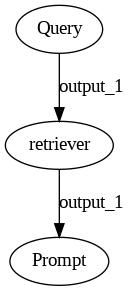

In [8]:
import matplotlib.pyplot as plt
from PIL import Image
pipe.draw("pipe.png")
img=Image.open("pipe.png")
img


## Asking the RAG Model Questions
----
We use the pipeline .run() method to ask a question. Since the output provided by our Prompt Node is a Haystack object, we retrieve in the way provided inside the print() function.

In [9]:
output = pipe.run(query="Who is most responsible for pollution")

print(output["answers"][0].answer)

The Obama administration "has been constrained by the Oil Pollution Act of 1990, which basically gives the responsible party the lead role in trying to not only fix the problem, but contain the problem."


In [10]:
# Here are some other examples you can use
examples = [
    "Who is most responsible for pollution",
    "What is the biggest damaging factor for the climate?",
    "What are some clean energy sources?",
    "How much does the average temperature of our planet rise per decade?"
]
# let's try all the examples
for example in examples:
    output = pipe.run(query=example)
    print(output["answers"][0].answer)

The Obama administration "has been constrained by the Oil Pollution Act of 1990, which basically gives the responsible party the lead role in trying to not only fix the problem, but contain the problem."
Burping cows.
Solar, wind and geothermal.
The average temperature of our planet has risen by around 1.62F (0.9C).
